In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/TL_in_RL

/content/drive/MyDrive/Transfer-Deep-Reinforcement-Learning-master


In [ ]:
!bash setup.sh

In [ ]:
pip install -r req.txt

  Using cached adal-1.2.2-py2.py3-none-any.whl (53 kB)
  Using cached ansiwrap-0.8.4-py2.py3-none-any.whl (8.5 kB)
  Using cached appdirs-1.4.3-py2.py3-none-any.whl (12 kB)
  Using cached argh-0.26.2-py2.py3-none-any.whl (30 kB)
  Using cached arrow-0.15.5-py2.py3-none-any.whl (46 kB)
  Using cached asn1crypto-1.3.0-py2.py3-none-any.whl (103 kB)
  Using cached astroid-2.3.3-py3-none-any.whl (205 kB)
  Using cached astropy-4.0-cp37-cp37m-manylinux1_x86_64.whl (6.5 MB)
  Using cached atomicwrites-1.3.0-py2.py3-none-any.whl (5.9 kB)
  Using cached attrs-19.3.0-py2.py3-none-any.whl (39 kB)
  Using cached autopep8-1.5.tar.gz (116 kB)
  Using cached Babel-2.8.0-py2.py3-none-any.whl (8.6 MB)
  Using cached backcall-0.1.0.zip (11 kB)
  Using cached backports.os-0.1.1-py3-none-any.whl (5.8 kB)
  Using cached backports.shutil_get_terminal_size-1.0.0-py2.py3-none-any.whl (6.5 kB)
  Using cached bcolz-1.2.1.tar.gz (1.5 MB)
  Using cached beautifulsoup4-4.8.2-py3-none-any.whl (106 kB)
  Using cache

In [ ]:
!pip install -U gym box2d-py tqdm > /dev/null 2>&1

In [ ]:
import random
from collections import namedtuple, deque
import pdb

import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

from tqdm.notebook import tqdm

import os
import pickle
path_to_project = 'storage/'

# Deep Q Network

In [ ]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64,
                 transform=None):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
            transform (callable): If NoneType: Some transform applied on the state
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.transform = transform
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        if self.transform:
            state = self.transform(state)
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0., is_continuous_action=False):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if is_continuous_action:
            return action_values.cpu().data.numpy()[0]
        else:
            # Epsilon-greedy action selection
            if random.random() > eps:
                return np.argmax(action_values.cpu().data.numpy())
            else:
                return random.choice(np.arange(self.action_size))
            

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


def dqn(env, agent, n_episodes=2000, max_t=200, eps_start=1.0, eps_end=0.01, eps_decay=0.995,
        checkpoint_name='checkpoint.pth', is_continuous_action=False, mean_score_threshold=200.0,
        do_print=False):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            # pdb.set_trace()
            action = agent.act(state, eps, is_continuous_action)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        # if i_episode % 100 == 0:
        #     if do_print: print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=mean_score_threshold:
            # print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            break
    torch.save(agent.qnetwork_local.state_dict(), checkpoint_name)
    return scores



def sample_cartpole_tasks(num_tasks, random_state, variable=None):
    if variable is not None:
        if variable == 'gravity':
            gravity = random_state.normal(loc=9.8, size=(num_tasks))
            tasks = [{'gravity': g} for g in gravity]

        elif variable == 'masscart':
            masscart = random_state.normal(loc=1.0, scale=0.25, size=(num_tasks))
            total_mass = np.array([m1 + 0.1 for m1 in masscart])
            tasks = [{'masscart': mc, 'total_mass': mt} for mc, mt in zip(masscart, total_mass)]

        elif variable == 'masspole':
            masspole = random_state.normal(loc=0.1, scale=0.025, size=(num_tasks))
            total_mass = np.array([m1 + 1.0 for m1 in masspole])
            tasks = [{'masspole': mp, 'total_mass': mt} for mp, mt, in zip(masspole, total_mass)]

        elif variable == 'length':
            length = random_state.normal(loc=0.5, scale=0.125, size=num_tasks)
            tasks = [{'length': l} for l in length]

        elif variable == 'polemass_length':
            polemass_length = random_state.normal(loc=0.05, scale=0.0125, size=num_tasks)
            tasks = [{'polemass_length': l} for l in polemass_length]
            
        elif variable == 'force_mag':
            force_mag = random_state.normal(loc=10, size=num_tasks)
            tasks = [{'force_mag': fg} for fg in force_mag]

        else:
            raise NotImplementedError(f"No such variable {variable}")
    else:
        # gravity = random_state.normal(loc=9.8, size=(num_tasks))
        masscart = random_state.normal(loc=1.0, scale=0.25, size=(num_tasks))
        masspole = random_state.normal(loc=0.1, scale=0.025, size=(num_tasks))
        total_mass = np.array([m1 + m2 for m1, m2 in zip(masscart, masspole)])
        length = random_state.normal(loc=0.5, scale=0.125, size=num_tasks)
        polemass_length = random_state.normal(loc=0.05, scale=0.0125, size=num_tasks)
        # force_mag = random_state.normal(loc=10, size=num_tasks)
        # tasks = [{'gravity': g, 'masscart': mc, 'masspole': mp, 'total_mass': mt, 'length': l,
        #             'polemass_length': pl, 'force_mag': fg} for g, mc, mp, mt, l, pl, fg in zip(gravity, 
        #             masscart, masspole, total_mass, length, polemass_length, force_mag)]
        tasks = [{'masscart': mc, 'masspole': mp, 'total_mass': mt, 'length': l,
                    'polemass_length': pl} for mc, mp, mt, l, pl in zip(masscart, 
                    masspole, total_mass, length, polemass_length)]
    return tasks


def set_task(env, task):
    for k, v in task.items():
        env.env.__dict__[k] = v
    return env

# Variables

In [ ]:
plots_path = os.path.join(path_to_project, 'dqn_cart_tasks/plots')
models_path = os.path.join(path_to_project, 'dqn_cart_tasks/models')
baseline_path = os.path.join(plots_path, 'baseline.png')
class Variables:
    SEED=42
    BASELINE_CHECKPOINT_NAME=os.path.join(models_path, 'CartPole_baseline_checkpoint_dqn.pth')
    NUM_SEEDS=5
    NUM_TASKS=5
    NUM_EPISODES=1500

# CartPole-v1

## Baseline

In [ ]:
env = gym.make('CartPole-v1')
env.seed(Variables.SEED)

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

print(f'Observation space: {s_size}')
print(f'Action space: {a_size}')

baseline = Agent(state_size=s_size, action_size=a_size, seed=0)

Observation space: 4
Action space: 2


In [ ]:
scores_baseline = dqn(env, baseline, checkpoint_name=Variables.BASELINE_CHECKPOINT_NAME, max_t=200, 
                      n_episodes=Variables.NUM_EPISODES, do_print=True, mean_score_threshold=400.0)

Episode 1500	Average Score: 172.99

In [ ]:
torch.save(baseline.qnetwork_local.state_dict(), os.path.join(models_path, 'baseline_qnetwork_local.pth'))
torch.save(baseline.qnetwork_target.state_dict(), os.path.join(models_path, 'baseline_qnetwork_target.pth'))

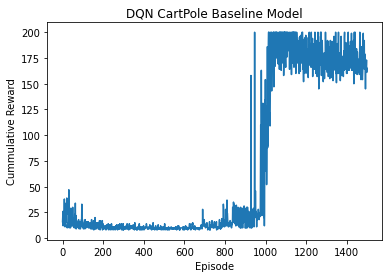

In [ ]:
plt.plot(scores_baseline)
plt.xlabel('Episode')
plt.ylabel('Cummulative Reward')
plt.title('DQN CartPole Baseline Model')
plt.savefig(os.path.join(plots_path, 'baseline.png'))
plt.show()

## New Tasks

In [ ]:
env = gym.make('CartPole-v1')

Variables.NUM_TASKS = 5
Variables.NUM_EPISODES = 1500
Variables.NUM_SEEDS = 5

random_state = np.random.RandomState(Variables.SEED)
tasks = sample_cartpole_tasks(Variables.NUM_TASKS, random_state)

history_transfer = []
history_scratch = []

average_transfer_per_task = []
variance_transfer_per_task = []

average_scratch_per_task = []
variance_scratch_per_task = []

models_path = os.path.join(path_to_project, 'dqn_cart_tasks/models')

for i, task in tqdm(enumerate(tasks), desc=f'Running {Variables.NUM_TASKS} tasks'):
    scores_transfer_per_seed = []
    scores_scratch_per_seed = []
    for seed in range(Variables.NUM_SEEDS):
        env.seed(seed)
        set_task(env, task)

        s_size = env.observation_space.shape[0]
        a_size = env.action_space.n

        # Transfer agent needs to load the weights for each new task
        agent_transfer = Agent(state_size=s_size, action_size=a_size, seed=seed)
        agent_transfer.qnetwork_local.load_state_dict(torch.load(os.path.join(models_path, 'baseline_qnetwork_local.pth')))
        agent_transfer.qnetwork_target.load_state_dict(torch.load(os.path.join(models_path, 'baseline_qnetwork_target.pth')))

        # Agent from scratch has its weights initialized randomly for each new task
        agent_scratch = Agent(state_size=s_size, action_size=a_size, seed=seed)

        # Train both
        scores_transfer = dqn(env, agent_transfer, n_episodes=Variables.NUM_EPISODES, max_t=200,
                              mean_score_threshold=500, checkpoint_name=os.path.join(models_path, f'CartPole_transfer_task_{i}'))
        scores_scratch = dqn(env, agent_scratch, n_episodes=Variables.NUM_EPISODES, max_t=200,
                             mean_score_threshold=500, checkpoint_name=os.path.join(models_path, f'CartPole_scratch_task_{i}'))
        
        scores_transfer_per_seed.append(scores_transfer)
        scores_scratch_per_seed.append(scores_scratch)
    
    average_transfer_per_task.append(np.average(scores_transfer_per_seed, axis=0))
    variance_transfer_per_task.append(np.var(scores_transfer_per_seed, axis=0))

    average_scratch_per_task.append(np.average(scores_scratch_per_seed, axis=0))
    variance_scratch_per_task.append(np.var(scores_scratch_per_seed, axis=0))

    history_transfer.append(scores_transfer_per_seed)
    history_scratch.append(scores_scratch_per_seed)

Running 5 tasks: 0it [00:00, ?it/s]

Episode 1500	Average Score: 197.41

In [ ]:
plots_path = os.path.join(path_to_project, 'dqn_cart_tasks/plots')
data_path = os.path.join(path_to_project, 'dqn_cart_tasks/data')

In [ ]:
save = True
if save:
    with open(os.path.join(data_path, 'history_transfer.list'), 'wb') as f:
        pickle.dump(history_transfer, f)
    with open(os.path.join(data_path,'history_scratch.list'), 'wb') as f:
        pickle.dump(history_scratch, f)
    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'wb') as f:
        pickle.dump(average_transfer_per_task, f)
    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'wb') as f:
        pickle.dump(variance_transfer_per_task, f)
    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'wb') as f:
        pickle.dump(average_scratch_per_task, f)
    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'wb') as f:
        pickle.dump(variance_scratch_per_task, f)
    with open(os.path.join(data_path, 'tasks.list'), 'wb') as f:
        pickle.dump(tasks, f)

In [ ]:
load = False
if load:
    # with open(os.path.join(data_path, 'history_transfer.list'), 'rb') as f:
    #     history_transfer = pickle.load(f)

    # with open(os.path.join(data_path,'history_scratch.list'), 'rb') as f:
    #     history_scratch = pickle.load(f)

    with open(os.path.join(data_path,'average_transfer_per_task.list'), 'rb') as f:
        average_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_transfer_per_task.list'), 'rb') as f:
        variance_transfer_per_task = pickle.load(f)

    with open(os.path.join(data_path,'average_scratch_per_task.list'), 'rb') as f:
        average_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path,'variance_scratch_per_task.list'), 'rb') as f:
        variance_scratch_per_task = pickle.load(f)

    with open(os.path.join(data_path, 'tasks.list'), 'rb') as f:
        tasks = pickle.load(f)

Transferring Local and Target Q Networks
{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


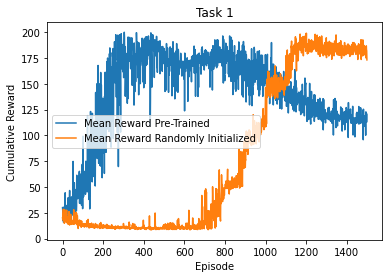

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


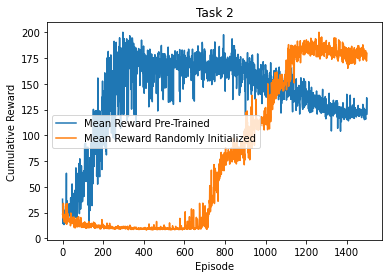

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


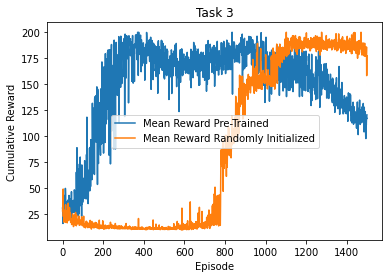

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


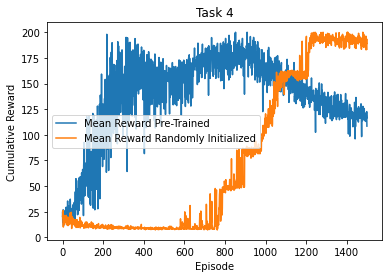

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


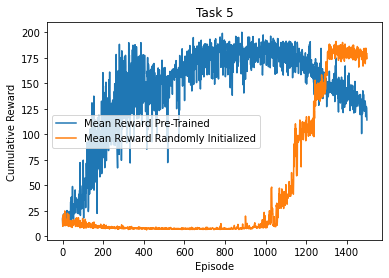

In [ ]:
# Varying each parameter
print('Transferring Local and Target Q Networks')
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    plt.plot(average)
    # plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    # plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'task_{i+1}_cart_dqn.png'))
    plt.show()

Transferring Local and Target Q Networks
{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


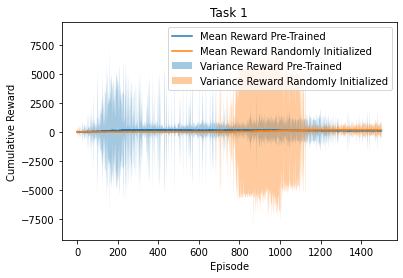

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


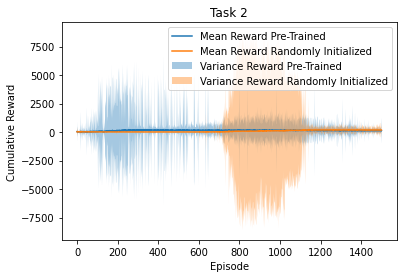

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


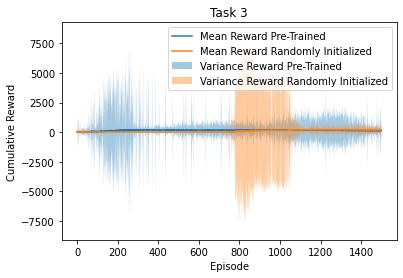

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


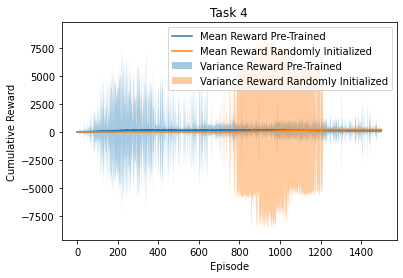

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


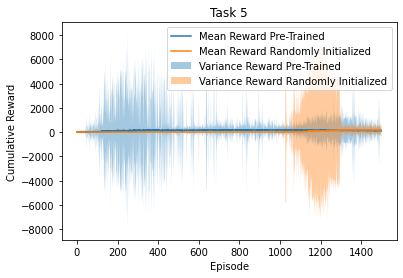

In [ ]:
# Varying each parameter
print('Transferring Local and Target Q Networks')
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    # plt.figure(figsize(12,6))
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_task_{i+1}_cart_dqn.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


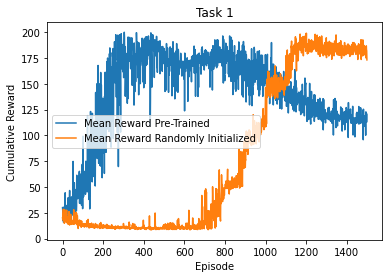

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


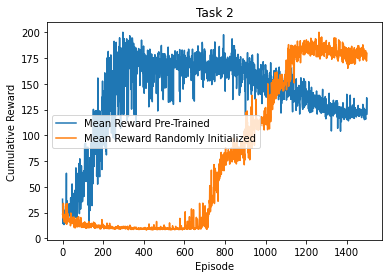

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


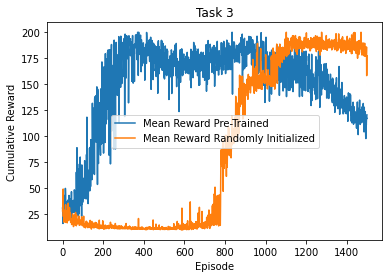

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


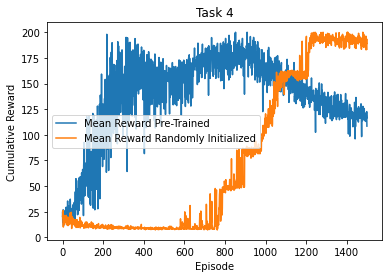

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


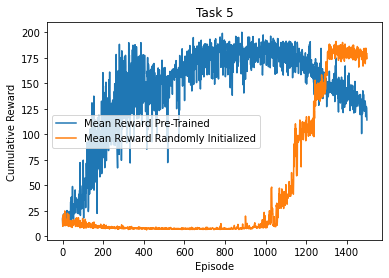

In [ ]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    plt.plot(average)
    # plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    # plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'task_{i+1}_cart_dqn.png'))
    plt.show()

{'masscart': 1.1241785382528082, 'masspole': 0.09414657607627049, 'total_mass': 1.2183251143290788, 'length': 0.4420727883984422, 'polemass_length': 0.04297140588448784}


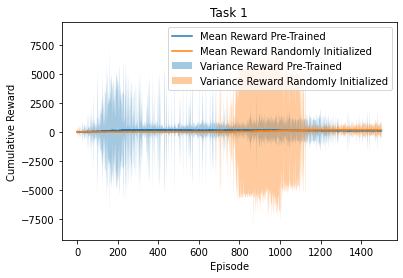

{'masscart': 0.9654339247072038, 'masspole': 0.1394803203876848, 'total_mass': 1.1049142450948886, 'length': 0.4417837808037179, 'polemass_length': 0.03733961099581971}


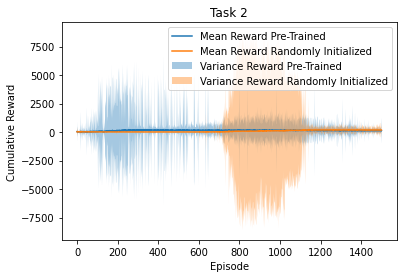

{'masscart': 1.1619221345251731, 'masspole': 0.11918586822882273, 'total_mass': 1.2811080027539958, 'length': 0.5302452839457543, 'polemass_length': 0.053928091657440926}


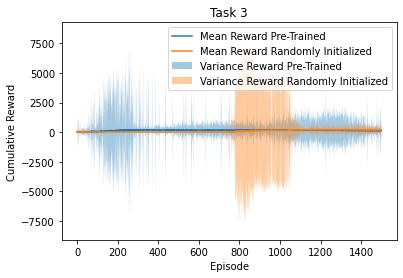

{'masscart': 1.3807574641020064, 'masspole': 0.0882631403516262, 'total_mass': 1.4690206044536327, 'length': 0.26083996941777526, 'polemass_length': 0.038649699055984865}


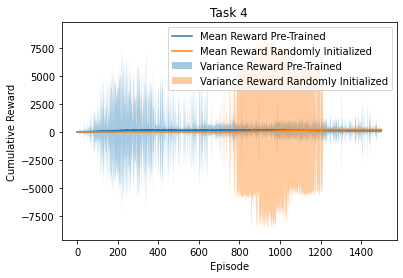

{'masscart': 0.941461656319166, 'masspole': 0.11356400108964912, 'total_mass': 1.055025657408815, 'length': 0.2843852709358709, 'polemass_length': 0.03234620373330886}


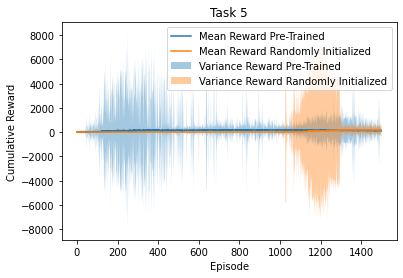

In [ ]:
# Varying each parameter
x_ticks = [i for i in range(Variables.NUM_EPISODES)]
for i in range(Variables.NUM_TASKS):
    average = average_transfer_per_task[i] 
    variance = variance_transfer_per_task[i]

    # plt.figure(figsize(12,6))
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    average = average_scratch_per_task[i] 
    variance = variance_scratch_per_task[i]
    plt.plot(average)
    plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

    print(tasks[i])
    plt.title(f"Task {i+1}")
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend(('Mean Reward Pre-Trained', 'Mean Reward Randomly Initialized',
                'Variance Reward Pre-Trained', 'Variance Reward Randomly Initialized'))
    plt.savefig(os.path.join(plots_path, f'w_variance_task_{i+1}_cart_dqn.png'))
    plt.show()

# Lunar Lander

In [ ]:
env2 = gym.make('LunarLander-v2')
env2.seed(0)

s_size = env2.observation_space.shape[0]
a_size = env2.action_space.n

print(f'Observation space: {s_size}')
print(f'Action space: {a_size}')

agent2_w_transfer = Agent(state_size=s_size, action_size=a_size, seed=0)
agent2_w_transfer.qnetwork_local.fc2 = baseline.qnetwork_local.fc2
agent2_w_transfer.qnetwork_target.fc2 = baseline.qnetwork_target.fc2

Observation space: 8
Action space: 4


## CartPole to Lunar Lander

In [ ]:
history_scores2_transfer = []
history_scores2_scratch = []

scores2_transfer_per_seed = []
scores2_scratch_per_seed = []
for seed in range(Variables.NUM_SEEDS):
    env.reset()
    env.seed(seed)

    agent2_w_transfer = Agent(state_size=s_size, action_size=a_size, seed=seed)
    agent2_w_transfer.qnetwork_local.fc2 = baseline.qnetwork_local.fc2
    agent2_w_transfer.qnetwork_target.fc2 = baseline.qnetwork_target.fc2

    scores2_w_transfer = dqn(env2, agent2_w_transfer, is_continuous_action=False, n_episodes=1000, 
                            mean_score_threshold=300)
    scores2_transfer_per_seed.append(scores2_w_transfer)

    agent2 = Agent(state_size=s_size, action_size=a_size, seed=0)
    scores2_scratch = dqn(env2, agent2, is_continuous_action=False, n_episodes=1000, mean_score_threshold=300)
    scores2_scratch_per_seed.append(scores2_scratch)

average_scores2_transfer = np.average(scores2_transfer_per_seed, axis=0)
variance_scores2_transfer = np.var(scores2_transfer_per_seed, axis=0)
history_scores2_transfer.append(scores2_transfer_per_seed)

average_scores2_scratch = np.average(scores2_scratch_per_seed, axis=0)
variance_scores2_scratch = np.var(scores2_scratch_per_seed, axis=0)
history_scores2_scratch.append(scores2_scratch_per_seed)

Episode 1000	Average Score: 52.25

In [ ]:
data_path = os.path.join(path_to_project, 'dqn_cart_tasks/data/dqn_cart_to_lander')

In [ ]:
save = False
if save:
    with open(os.path.join(data_path, 'history_scores2_transfer.list'), 'wb') as f:
        pickle.dump(history_scores2_transfer, f)
    with open(os.path.join(data_path,'history_scores2_scratch.list'), 'wb') as f:
        pickle.dump(history_scores2_scratch, f)
    with open(os.path.join(data_path,'average_scores2_transfer.list'), 'wb') as f:
        pickle.dump(average_scores2_transfer, f)
    with open(os.path.join(data_path,'variance_scores2_transfer.list'), 'wb') as f:
        pickle.dump(variance_scores2_transfer, f)
    with open(os.path.join(data_path,'average_scores2_scratch.list'), 'wb') as f:
        pickle.dump(average_scores2_scratch, f)
    with open(os.path.join(data_path,'variance_scores2_scratch.list'), 'wb') as f:
        pickle.dump(variance_scores2_scratch, f)

In [ ]:
data_path = os.path.join(path_to_project, 'dqn_cart_tasks/data/dqn_cart_to_lander')

load = False
if load:
    with open(os.path.join(data_path, 'history_scores2_transfer.list'), 'rb') as f:
        history_scores2_transfer = pickle.load(f)

    # with open(os.path.join(data_path,'history_scores2_scratch.list'), 'rb') as f:
    #     history_scores2_scratch = pickle.load(f)

    with open(os.path.join(data_path,'average_scores2_transfer.list'), 'rb') as f:
        average_scores2_transfer = pickle.load(f)

    with open(os.path.join(data_path,'variance_scores2_transfer.list'), 'rb') as f:
        variance_scores2_transfer = pickle.load(f)

    with open(os.path.join(data_path,'average_scores2_scratch.list'), 'rb') as f:
        average_scores2_scratch = pickle.load(f)

    with open(os.path.join(data_path,'variance_scores2_scratch.list'), 'rb') as f:
        variance_scores2_scratch = pickle.load(f)

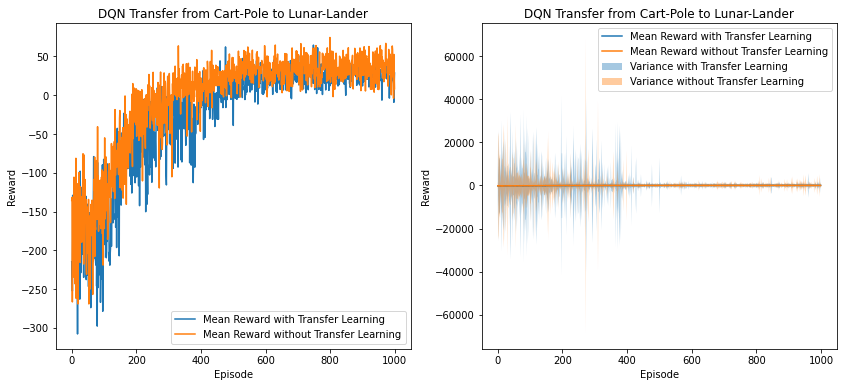

In [ ]:
plots_path_2 = os.path.join(path_to_project, 'dqn_cart_tasks/plots')

x_ticks = [i for i in range(1000)]
average = average_scores2_transfer 
variance = variance_scores2_transfer

plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(average)
# plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

average = average_scores2_scratch
variance = variance_scores2_scratch
plt.plot(average)
# plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

plt.title(f"DQN Transfer from Cart-Pole to Lunar-Lander")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend((('Mean Reward with Transfer Learning', 'Mean Reward without Transfer Learning')))
plt.savefig(os.path.join(plots_path_2, 'cart_to_lander.png'))

plt.subplot(122)
average = average_scores2_transfer 
variance = variance_scores2_transfer

plt.plot(average)
plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

average = average_scores2_scratch
variance = variance_scores2_scratch
plt.plot(average)
plt.fill_between(x_ticks, average+variance, average-variance, alpha=0.4)

plt.title(f"DQN Transfer from Cart-Pole to Lunar-Lander")
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend((('Mean Reward with Transfer Learning', 'Mean Reward without Transfer Learning', 
             'Variance with Transfer Learning', 'Variance without Transfer Learning')))
plt.savefig(os.path.join(plots_path_2, 'w_variance_cart_to_lander.png'))
plt.show()
